In [1]:
import time
import os
import urllib.parse

import numpy as np
import tensorflow as tf
from tensorflow.core.example.example_pb2 import Example
from tensorflow.core.example.feature_pb2 import Feature
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

tf.logging.set_verbosity(tf.logging.INFO) 

# Get data
We are using the Census data. We are proposing a process to assess algorithmic bias in models, so instead of using the classification for whether people have >50k income, it will be used to classify if people should get a loan.

In [2]:
DOWNLOAD = False

csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

input_features = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]

categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

label_column = 'loan'

csv_path = "data/adult.csv"

if DOWNLOAD:
    csv_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skiprows=[0], skipinitialspace=True)

# Converting Loan column to 1 if >50K
df[label_column] = df[label_column].apply(lambda x: ">50K" in x).astype(int)

# for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         df[c] = pd.to_numeric(df[c])

# Delete unused column
del df["fnlwgt"] 

X_display = df.drop('loan', axis=1)
y_display = df['loan']
        
# int_columns = df.select_dtypes(['int64']).columns
# df[int_columns] = df[int_columns].astype('int64')

# cat_columns = df.select_dtypes(['object']).columns
# df[cat_columns] = df[cat_columns].astype('category')
# df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

g = df.groupby('loan')
df = df.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
df = df.sample(100)

df.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
2545,40,Private,Some-college,15,Married-civ-spouse,Exec-managerial,Unmarried,White,Male,0,0,60,United-States,0
6946,18,State-gov,Some-college,9,Married-civ-spouse,Other-service,Not-in-family,White,Female,0,0,50,United-States,0
6337,70,Private,9th,13,Divorced,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,1
2997,29,Private,Bachelors,10,Never-married,Machine-op-inspct,Husband,White,Female,0,0,40,United-States,0
9147,18,Private,11th,9,Never-married,Transport-moving,Husband,White,Female,0,0,40,United-States,1


In [3]:
model_folder = 'trained_model'

examples_file = 'data.tfrecord'

model_path = os.path.join(os.getcwd(), model_folder)
examples_path = os.path.join(os.getcwd(), examples_file)

In [4]:
X = df.drop(label_column, axis=1)
y = df[label_column]

dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
print(dtypes)

#Normalising to increase accuracy
# for k,dtype in dtypes:
#     if dtype == "float32":
#         X[k] -= X[k].mean()
#         X[k] /= X[k].std()

[('age', 'int64'), ('workclass', 'object'), ('education', 'object'), ('education-num', 'int64'), ('marital-status', 'object'), ('occupation', 'object'), ('relationship', 'object'), ('ethnicity', 'object'), ('gender', 'object'), ('capital-gain', 'int64'), ('capital-loss', 'int64'), ('hours-per-week', 'int64'), ('native-country', 'object')]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [6]:
BATCH_SIZE = 40
num_epochs = 1
shuffle = True

In [7]:

# gender = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="gender", hash_bucket_size=1000, dtype=tf.int8))

# ethnicity = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             key="ethnicity", hash_bucket_size=1000, dtype=tf.int8))

# marital_status = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "marital-status", hash_bucket_size=100, dtype=tf.int8))

# relationship = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "relationship", hash_bucket_size=100, dtype=tf.int8))

# workclass = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "workclass", hash_bucket_size=100, dtype=tf.int8))

# occupation = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=1000, dtype=tf.int8))

# native_country = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=1000, dtype=tf.int8))

# education = tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=1000, dtype=tf.int8))


gender = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            key="gender", hash_bucket_size=1000))

ethnicity = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            key="ethnicity", hash_bucket_size=1000))

marital_status = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            "marital-status", hash_bucket_size=100))

relationship = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            "relationship", hash_bucket_size=100))

workclass = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            "workclass", hash_bucket_size=100))

occupation = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            "occupation", hash_bucket_size=1000))

native_country = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            "native-country", hash_bucket_size=1000))

education = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_hash_bucket(
            "education", hash_bucket_size=1000))


# occupation = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "occupation", hash_bucket_size=1000),
#         dimension=8)

# native_country = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "native-country", hash_bucket_size=1000),
#         dimension=8)

# education = tf.feature_column.embedding_column(
#         tf.feature_column.categorical_column_with_hash_bucket(
#             "education", hash_bucket_size=1000),
#         dimension=8)

In [8]:
age = tf.feature_column.numeric_column("age")
education_num = tf.feature_column.numeric_column("education-num")
capital_gain = tf.feature_column.numeric_column("capital-gain")
capital_loss  = tf.feature_column.numeric_column("capital-loss")
hours_per_week = tf.feature_column.numeric_column("hours-per-week")

age = tf.feature_column.bucketized_column(
    age, boundaries=list(range(0,100,5)))
education_num = tf.feature_column.bucketized_column(
    education_num, boundaries=list(range(0,16,1)))
capital_gain = tf.feature_column.bucketized_column(
    capital_gain, boundaries=list(range(0,100000,10000)))
capital_loss  = tf.feature_column.bucketized_column(
    capital_loss, boundaries=list(range(0,4000,1000)))
hours_per_week = tf.feature_column.bucketized_column(
    hours_per_week, boundaries=list(range(0,100,5)))

In [9]:
all_columns = [
    workclass,
    marital_status,
    gender,
    relationship,
    ethnicity,
    education,
    native_country,
    occupation,
    age,
    education_num,
    capital_gain,
    capital_loss,
    hours_per_week,
]

In [10]:
model_dir = "models/model_DEEP_" + str(int(time.time()))



m = tf.estimator.BoostedTreesClassifier(
            model_dir=model_dir,
            feature_columns=all_columns,
            n_batches_per_layer=int(0.5*X.shape[0]/BATCH_SIZE),
)

# m = tf.estimator.DNNClassifier(
#             model_dir=model_dir,
#             feature_columns=all_columns,
#             hidden_units=[100,100,100])



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/model_DEEP_1543861039', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe983a67b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
%%time 

train_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

m.train(input_fn=train_input_fn)

print('training done')

INFO:tensorflow:Calling model_fn.


In [ ]:
eval_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

results = m.evaluate(input_fn=eval_input_fn)

print('\nAccuracy: %s' % results['accuracy'])

In [ ]:
prediction_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

pred_gen = m.predict(input_fn=prediction_input_fn)

pred_list = []

for pred, actual in zip(pred_gen, y):
    tmp = []
    tmp.append(pred["logits"][0])   
    tmp.append(pred["logistic"][0])
    tmp.append(pred["probabilities"][0])
    tmp.append(pred["probabilities"][1])
    tmp.append(actual)
    tmp.append(pred["class_ids"][0])
    tmp.append(int(pred["class_ids"][0] == actual))
    tmp.append(int(pred["class_ids"][0] != actual and actual == 1))
    tmp.append(int(pred["class_ids"][0] != actual and actual == 0))

    #get index of maximum value of sigmoid. it will correspond to class
    pred_list.append(tmp)


pred_cols = ["logits", "logistic", "prob_neg", "prob_pos",
            "actual", "predicted", "is_correct", 
             "false_positive", "false_negative"]

pred_df = pd.DataFrame(pred_list, columns=pred_cols)
pred_df

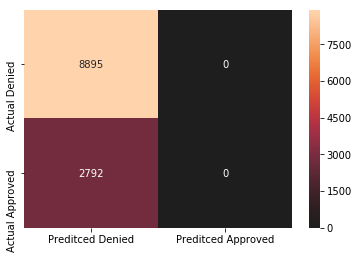

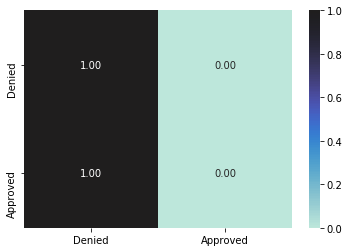

In [22]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(
    pred_df["actual"],
    pred_df["predicted"])

confusion_df = pd.DataFrame(confusion, 
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

confusion_scaled = \
    confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]

confusion_scaled_df = pd.DataFrame(confusion_scaled, 
            index=["Denied", "Approved"], 
            columns=["Denied", "Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)
plt.show()

sn.heatmap(confusion_scaled_df, annot=True, fmt='.2f', center=1)
plt.show()

0.5039484450070948


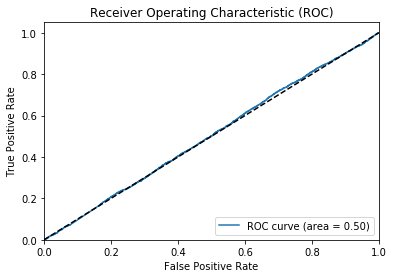

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(
        pred_df["actual"].values, pred_df["prob_pos"].values)

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
predicted = pred_df["predicted"]
actual = pred_df["actual"]

TP = np.count_nonzero(predicted * actual)
TN = np.count_nonzero((predicted - 1) * (actual - 1))
FP = np.count_nonzero(predicted * (actual - 1))
FN = np.count_nonzero((predicted - 1) * actual)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

print(precision, recall, f1)

#### Data Analysis

In [ ]:
X_analysis = X_display.copy()
X_analysis = X_analysis.join(pred_df)

X_analysis.tail(5)

In [ ]:
X_display.gender.value_counts().plot.barh()

In [ ]:
X_display.plot("gender", "predicted")

In [ ]:
flds = ["gender", "age", "education-num", "capital-gain", 
                  "capital-loss", "hours-per-week"]


enc_summ = X_display[flds].groupby("gender", as_index=False).mean()
enc_summ

# Explainability with SHAP

In [ ]:
import shap
shap.initjs()


In [ ]:
tf_shap_idx = 39
tf_shap_x = X.iloc[tf_shap_idx,:]
tf_shap_display = X_display.iloc[tf_shap_idx,:]
tf_shap_y = y.iloc[tf_shap_idx]
print(tf_shap_y)

In [ ]:



def shap_predict_proba(shap_X):
    tmp_df = pd.DataFrame(data=shap_X, columns=input_features)
    # Converting to int
#     for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         tmp_df[c] = pd.to_numeric(tmp_df[c])
    
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=tmp_df,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

    pred_gen = m.predict(input_fn=predict_input_fn)
    pred_list = []
    for pred in pred_gen:
        pred_list.append(pred["logits"][0])
    pred_arr = np.array(pred_list)

    return pred_arr

tf_explainer = shap.KernelExplainer(
                        shap_predict_proba, 
                        X.iloc[:100,:], 
                        link="identity")


In [ ]:
tf_shap_values = tf_explainer.shap_values(tf_shap_x, nsamples=500)

In [ ]:
shap.force_plot(tf_explainer.expected_value, tf_shap_values, tf_shap_display)

In [ ]:
tf_shap_idx_multi_from = 15
tf_shap_idx_multi_to = 40
tf_shap_x_multi = X.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to,:]
tf_shap_display_multi = X_display.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to,:]
tf_shap_y_multi = y.iloc[tf_shap_idx_multi_from:tf_shap_idx_multi_to]
print(tf_shap_y_multi)

In [ ]:
tf_shap_values_multi = tf_explainer.shap_values(tf_shap_x_multi, nsamples=500)

In [ ]:
shap.force_plot(tf_explainer.expected_value, tf_shap_values_multi, tf_shap_display_multi)

In [ ]:
shap.dependence_plot("gender", 
                     tf_shap_values_multi, 
                     tf_shap_x_multi, 
                     display_features=tf_shap_display_multi)

In [ ]:
shap.summary_plot(tf_shap_values_multi, tf_shap_x_multi)


# Census income classification with Keras

We use keras to perform this computation


In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras.models import Model
from keras.layers.embeddings import Embedding
from tqdm import tqdm
import shap

In [ ]:
# build model
input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss='binary_crossentropy')
regression.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_test[k].values for k,t in dtypes], y_test)
)

In [ ]:
def f(X):
    values = regression.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values
keras_explainer = shap.KernelExplainer(f, X.iloc[:100,:])

In [ ]:
keras_idx = 10
keras_x = X.iloc[keras_idx,:]
keras_y = y.iloc[keras_idx]
keras_shap_values = keras_explainer.shap_values(keras_x, nsamples=500)

In [ ]:
shap.force_plot(keras_explainer.expected_value, keras_shap_values, keras_x)

In [ ]:
keras_y

# LIME on Tensorflow

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
tf_lime_explainer = LimeTabularExplainer(
                X_train.values,
                class_names=["No", "Yes"],
                feature_names=list(X_train.columns),
                categorical_features=categorical_features)

In [ ]:

def lime_predict_proba(lime_X):
    tmp_df = pd.DataFrame(data=lime_X, columns=input_features)
    # Converting to int
#     for c in ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]:
#         tmp_df[c] = pd.to_numeric(tmp_df[c])
    
    float_columns = tmp_df.select_dtypes(['float64']).columns
    tmp_df[float_columns] = tmp_df[float_columns].astype('int64')
    
    predict_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=tmp_df,
        batch_size=BATCH_SIZE,
        num_epochs=num_epochs,
        shuffle=shuffle)

    pred_gen = m.predict(input_fn=predict_input_fn)
    pred_list = []
    for pred in pred_gen:
        tmp = []
        pred_list.append(pred["probabilities"])
        
    pred_arr = np.array(pred_list)

    
    return pred_arr

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[0,:], lime_predict_proba, num_features=13) 

In [ ]:
tf_lime_explanation.as_pyplot_figure()

In [ ]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)